The goal of this excerices is to get familiar with DEAP library.

I took the one-max task. At first, all individuals are random bit strings. We evolve our population until one of individuals contains only 1's and no 0's.

In [84]:
import random

from deap import base, creator, tools
import numpy as np
import matplotlib.pyplot as plt

Define classes for fitness and individual

In [85]:
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

In [86]:
toolbox = base.Toolbox()
# genes of individual are randomly initialized with 0 or 1
toolbox.register('attr_bool', random.randint, 0, 1)
# here we say that we repeatedly apply 'attr_bool' 100 and put results into Individual
# Thus, we initialize our Individual with a random bit string of length 100
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_bool, 100)
# initialize population by creating N inidividuals
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

Evaluation functions. Here we just count number of 1's in an individual.

In [87]:
def evalOneMax(individual):
    return sum(individual),

Define genetic operators.

In [88]:
toolbox.register('evaluate', evalOneMax)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
toolbox.register('select', tools.selTournament, tournsize=3)

Define probabilites:
* CXPB - probability with which two individuals cross
* MUTPB - probability of an individual being mutated

In [89]:
CXPB, MUTPB = 0.5, 0.2

In [90]:
def main():
    # logs for visualization
    mins, maxes, avgs = [], [], []
    
    pop = toolbox.population(n=300)
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
        
    fits = [ind.fitness.values[0] for ind in pop]
    g = 0
    while max(fits) < 100 and g < 1000:
        g += 1
        
        # select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Since toolbox operators will modify objects inplace,
        # we need to clone each individuals to avoid any
        # unexpected side effects
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                # mark fitnesses of modified individuals
                # as invalid. In the future we will need to
                # reevaluate fitness of each individual,
                # but we'll do it only for modified ones
                # to save resources
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # offspring are a new population now
        pop[:] = offspring

        fits = [ind.fitness.values[0] for ind in pop]
        # log info about current generation fitnesses
        mins.append(np.min(fits))
        maxes.append(np.max(fits))
        avgs.append(np.mean(fits))
        
    # visualize evolution
    plt.plot(mins, color='red')
    plt.plot(maxes, color='orange')
    plt.plot(avgs, color='blue')
    plt.show()
    

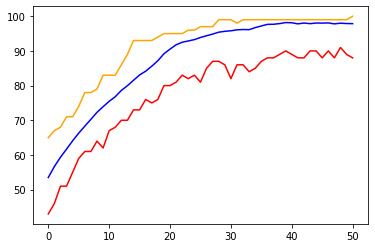

In [57]:
main()

### A shorter version
Make use of **algorithms** package

In [91]:
from deap import algorithms

In [92]:
def main():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register('avg', np.mean)
    stats.register('std', np.std)
    stats.register('min', np.min)
    stats.register('max', np.max)
    
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40,
                                   stats=stats, halloffame=hof, verbose=False)
    
    # visualize evolution
#     plt.plot(list(map(lambda x: x['min'], log)), color='red')
#     plt.plot(list(map(lambda x: x['max'], log)), color='orange')
#     plt.plot(list(map(lambda x: x['avg'], log)), color='blue')
#     plt.show()
    return pop, log, hof

In [80]:
%timeit pop, log, hof = main()

619 ms ± 4.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numpy version
Individual class in inherited from numpy.ndarray instead of python list.

In [71]:
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

Copy is required because slice of numpy array returns a view. So we cannot make swap correctly.

In [72]:
def cxTwoPointCopy(ind1, ind2):
    size = len(ind1)
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else:
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1
        
    ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] \
        = ind2[cxpoint1:cxpoint2].copy(), ind2[cxpoint1:cxpoint2].copy()
    
    return ind1, ind2

In [73]:
toolbox.register('mate', cxTwoPointCopy)

In [78]:
def main():
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1, similar=np.array_equal)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register('avg', np.mean)
    stats.register('std', np.std)
    stats.register('min', np.min)
    stats.register('max', np.max)
    
    
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40,
                                   stats=stats, halloffame=hof, verbose=False)
    
    # visualize evolution
#     plt.plot(list(map(lambda x: x['min'], log)), color='red')
#     plt.plot(list(map(lambda x: x['max'], log)), color='orange')
#     plt.plot(list(map(lambda x: x['avg'], log)), color='blue')
#     plt.show()
    return pop, log, hof

In [79]:
%timeit _ = main()

624 ms ± 9.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Now let's play a bit

In [93]:
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

In [94]:
toolbox = base.Toolbox()
# genes of individual are randomly initialized with 0 or 1
toolbox.register('attr_bool', random.randint, 0, 1)
# here we say that we repeatedly apply 'attr_bool' 100 and put results into Individual
# Thus, we initialize our Individual with a random bit string of length 100
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_bool, 30)
# initialize population by creating N inidividuals
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

In [96]:
def evalOneMax(individual):
    return sum(individual),

In [145]:
toolbox.register('evaluate', evalOneMax)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.01)
toolbox.register('select', tools.selRoulette)

In [146]:
def main(npop=20, ngen=100):
    pop = toolbox.population(n=npop)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register('avg', np.mean)
    stats.register('std', np.std)
    stats.register('min', np.min)
    stats.register('max', np.max)
    
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=1.0, mutpb=1.0, ngen=ngen,
                                   stats=stats, halloffame=hof, verbose=False)
    
    return pop, log, hof

Run 50 Monte-Carlo simulations and average the results

The results are not satisfactory. Maybe it is because I use roulette selection, and since all fitnesses are somewhere in the range (18, 25), they have almost the same probability ($\pm1\%$) of being chosen as parents. Therefore, the most fit do not have that big advantage of propagating their genes.

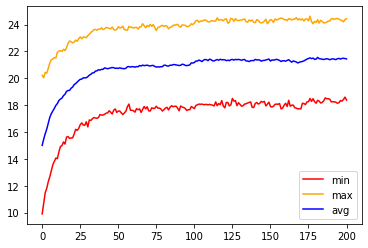

In [147]:
logs = []
for i in range(50):
    pop, log, hof = main(ngen=200)
    logs.append(log)
    
min_logs = list(map(lambda log: list(map(lambda x: x['min'], log)), logs))
min_logs = np.mean(min_logs, axis=0)
max_logs = list(map(lambda log: list(map(lambda x: x['max'], log)), logs))
max_logs = np.mean(max_logs, axis=0)
avg_logs = list(map(lambda log: list(map(lambda x: x['avg'], log)), logs))
avg_logs = np.mean(avg_logs, axis=0)
# visualize evolution
plt.plot(min_logs, color='red', label='min')
plt.plot(max_logs, color='orange', label='max')
plt.plot(avg_logs, color='blue', label='avg')
plt.legend(loc='best')
plt.show()

If I change population size to 40, the graphs shift up. We obtain a slightly better result, however none of individuals still don't reach the state with all 1's.

Why is it better? Probably because we have more variability in population, so we have a bit greater number of fit individuals.



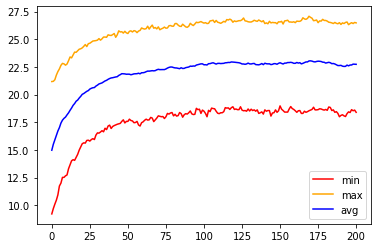

In [148]:
logs = []
for i in range(50):
    pop, log, hof = main(npop=40, ngen=200)
    logs.append(log)
    
min_logs = list(map(lambda log: list(map(lambda x: x['min'], log)), logs))
min_logs = np.mean(min_logs, axis=0)
max_logs = list(map(lambda log: list(map(lambda x: x['max'], log)), logs))
max_logs = np.mean(max_logs, axis=0)
avg_logs = list(map(lambda log: list(map(lambda x: x['avg'], log)), logs))
avg_logs = np.mean(avg_logs, axis=0)
# visualize evolution
plt.plot(min_logs, color='red', label='min')
plt.plot(max_logs, color='orange', label='max')
plt.plot(avg_logs, color='blue', label='avg')
plt.legend(loc='best')
plt.show()

Increase probability of gene mutation to 5%. Performance decreased. It is probably due to too much randomness in population.

In [159]:
toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)

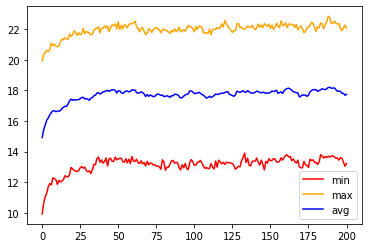

In [160]:
logs = []
for i in range(50):
    pop, log, hof = main(npop=20, ngen=200)
    logs.append(log)
    
min_logs = list(map(lambda log: list(map(lambda x: x['min'], log)), logs))
min_logs = np.mean(min_logs, axis=0)
max_logs = list(map(lambda log: list(map(lambda x: x['max'], log)), logs))
max_logs = np.mean(max_logs, axis=0)
avg_logs = list(map(lambda log: list(map(lambda x: x['avg'], log)), logs))
avg_logs = np.mean(avg_logs, axis=0)
# visualize evolution
plt.plot(min_logs, color='red', label='min')
plt.plot(max_logs, color='orange', label='max')
plt.plot(avg_logs, color='blue', label='avg')
plt.legend(loc='best')
plt.show()

If we turn off mutation, the graphs converge to a single point. We do not have any randomness in our population, so there is no exploration in our algorithm. It just converges to the best solution it can get with available individuals

In [161]:
toolbox.register('mutate', tools.mutFlipBit, indpb=0.00)

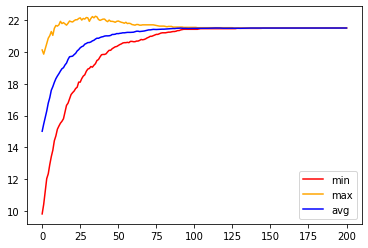

In [163]:
logs = []
for i in range(50):
    pop, log, hof = main(npop=20, ngen=200)
    logs.append(log)
    
min_logs = list(map(lambda log: list(map(lambda x: x['min'], log)), logs))
min_logs = np.mean(min_logs, axis=0)
max_logs = list(map(lambda log: list(map(lambda x: x['max'], log)), logs))
max_logs = np.mean(max_logs, axis=0)
avg_logs = list(map(lambda log: list(map(lambda x: x['avg'], log)), logs))
avg_logs = np.mean(avg_logs, axis=0)
# visualize evolution
plt.plot(min_logs, color='red', label='min')
plt.plot(max_logs, color='orange', label='max')
plt.plot(avg_logs, color='blue', label='avg')
plt.legend(loc='best')
plt.show()

If we add 50 to each fitness value, the results start to look like a horizontal line. The reason is that now all probabilities are almost the same, so the most fit individuals have almost no advantage over less fit ones. That means that their genes do not have higher probability to propagate further.

In [164]:
def evalOneMax(individual):
    return sum(individual) + 50,

In [165]:
toolbox.register('evaluate', evalOneMax)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.01)
toolbox.register('select', tools.selRoulette)

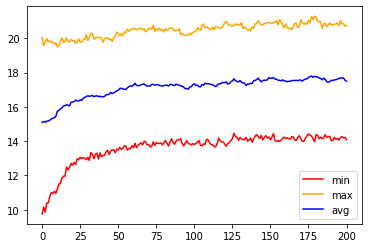

In [166]:
logs = []
for i in range(50):
    pop, log, hof = main(npop=20, ngen=200)
    logs.append(log)
    
min_logs = list(map(lambda log: list(map(lambda x: x['min'], log)), logs))
min_logs = np.mean(min_logs, axis=0) - 50
max_logs = list(map(lambda log: list(map(lambda x: x['max'], log)), logs))
max_logs = np.mean(max_logs, axis=0) - 50
avg_logs = list(map(lambda log: list(map(lambda x: x['avg'], log)), logs))
avg_logs = np.mean(avg_logs, axis=0) - 50
# visualize evolution
plt.plot(min_logs, color='red', label='min')
plt.plot(max_logs, color='orange', label='max')
plt.plot(avg_logs, color='blue', label='avg')
plt.legend(loc='best')
plt.show()

If an individual has fitness less than average - set it to 0. Now, algorithm succeeds to reach the maximum value, because most fit individuals have clear advantage over less fit ones, so their genes are much more likely to propagate further.

In [172]:
def evalOneMax(individual):
    return sum(individual),

In [173]:
toolbox.register('evaluate', evalOneMax)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.01)
toolbox.register('select', tools.selRoulette)

In [174]:
CXPB, MUTPB = 1.0, 1.0

In [198]:
def main(npop, ngen):
    # logs for visualization
    mins, maxes, avgs = [], [], []
    
    pop = toolbox.population(n=npop)
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit if fit >= (np.mean(fitnesses),) else (0,)
        
    fits = [ind.fitness.values[0] for ind in pop]
    g = 0
    while max(fits) < 100 and g < ngen:
        g += 1
        
        # select the next generation individuals
        offspring = toolbox.select(pop, len(pop))
        # Since toolbox operators will modify objects inplace,
        # we need to clone each individuals to avoid any
        # unexpected side effects
        offspring = list(map(toolbox.clone, offspring))

        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                # mark fitnesses of modified individuals
                # as invalid. In the future we will need to
                # reevaluate fitness of each individual,
                # but we'll do it only for modified ones
                # to save resources
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluate, invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit if fit >= (np.mean(fitnesses),) else (0,)

        # offspring are a new population now
        pop[:] = offspring

        fits = [ind.fitness.values[0] for ind in pop]
        # log info about current generation fitnesses
        mins.append(np.min(fits))
        maxes.append(np.max(fits))
        avgs.append(np.mean(fits))
        
    return mins, maxes, avgs
    

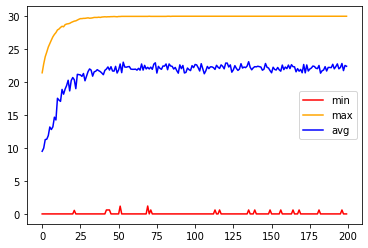

In [199]:
min_logs, max_logs, avg_logs = [], [], []
for i in range(50):
    mins, maxes, avgs = main(npop=20, ngen=200)
    min_logs.append(mins)
    max_logs.append(maxes)
    avg_logs.append(avgs)
    
min_logs = np.mean(min_logs, axis=0)
max_logs = np.mean(max_logs, axis=0)
avg_logs = np.mean(avg_logs, axis=0)
# visualize evolution
plt.plot(min_logs, color='red', label='min')
plt.plot(max_logs, color='orange', label='max')
plt.plot(avg_logs, color='blue', label='avg')
plt.legend(loc='best')
plt.show()

# Summary
Two main conclusions that we can draw:
* It is important to pass the right amount of randomness into algorithm. Too much - it is a random search. Too low - no exporation.
* For roulette selection it is crucial that the most fit individuals have a clear advantage. Otherwise, if their probabilities of selection are almost the same as those of less fit ones, their genes will not propagate into future generations.